In [49]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}


for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])


time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = 0
    x_predictor[m] = 0
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        if idx_i ==0:
            y_forced_response[m] = dic_forced_response_ssp585[m][i][131:164]
            x_predictor[m] = dic_processed_ssp585[m][i][131:164,:,:]
        else:
            y_forced_response[m] = np.concatenate([y_forced_response[m],dic_forced_response_ssp585[m][i][131:164]])
            x_predictor[m] = np.concatenate([x_predictor[m], dic_processed_ssp585[m][i][131:164,:,:]],axis=0)    

# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.var(arr_tmp,axis=0)
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_41520/2131114778.py:70: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_41520/2131114778.py:72: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


In [50]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.from_numpy(np.nan_to_num(x_predictor[m]).reshape(x_predictor[m].shape[0],x_predictor[m].shape[1]*x_predictor[m].shape[2])).to(torch.float64)
    y_train[m] = torch.from_numpy(np.nan_to_num(y_forced_response[m])).to(torch.float64)

    nans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()))[0]


alpha_range = np.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0,10000.0])
lambda_range = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0,10000.0])


with open('alpha_range.npy', 'wb') as f:
    np.save(f, alpha_range)

with open('lambda_range.npy', 'wb') as f:
    np.save(f, lambda_range)

# Read the results.

In [51]:
# read robust regression files
file = open('results/betas_robust.pkl', 'rb')
beta_robust = pickle.load(file)
file.close()

file = open('results/rmse_robust.pkl', 'rb')
rmse_robust = pickle.load(file)
file.close()

file = open('results/weight_robust.pkl', 'rb')
weights_robust = pickle.load(file)
file.close()

# Plot the worst RMSE map

In [38]:
a_map = np.zeros((alpha_range.shape[0],lambda_range.shape[0]))
best_idx_alpha = 0
best_idx_lambda = 0
best_value = 100000000

worst_loo_idx = {}


# for each pair (alpha, lambda)
for idx_alpha, alpha_ in enumerate(alpha_range):
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        
        a_map[idx_alpha,idx_lambda] = np.array(list(rmse_robust[(alpha_,lambda_)].values())).max()
        worst_loo_idx[(alpha_,lambda_)] = max(rmse_robust[(alpha_,lambda_)], key=rmse_robust[(alpha_,lambda_)].get)

        if a_map[idx_alpha,idx_lambda] < best_value:
            best_idx_alpha = idx_alpha
            best_idx_lambda = idx_lambda
            best_value = a_map[idx_alpha,idx_lambda]
        

In [39]:
best_alpha = alpha_range[best_idx_alpha]
best_lambda = lambda_range[best_idx_lambda]

print("Best alpha value ",best_alpha)
print("Best lambda value ",best_lambda)
print("Best alpha index ",best_idx_alpha)
print("Best lambda index ",best_idx_lambda)

Best alpha value  100.0
Best lambda value  10.0
Best alpha index  15
Best lambda index  8


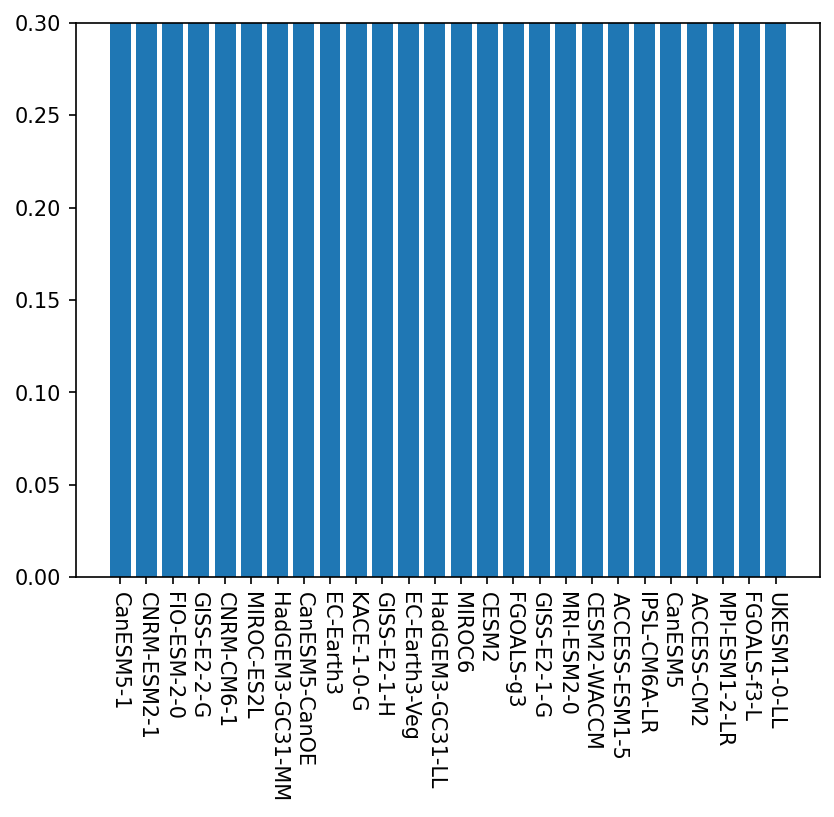

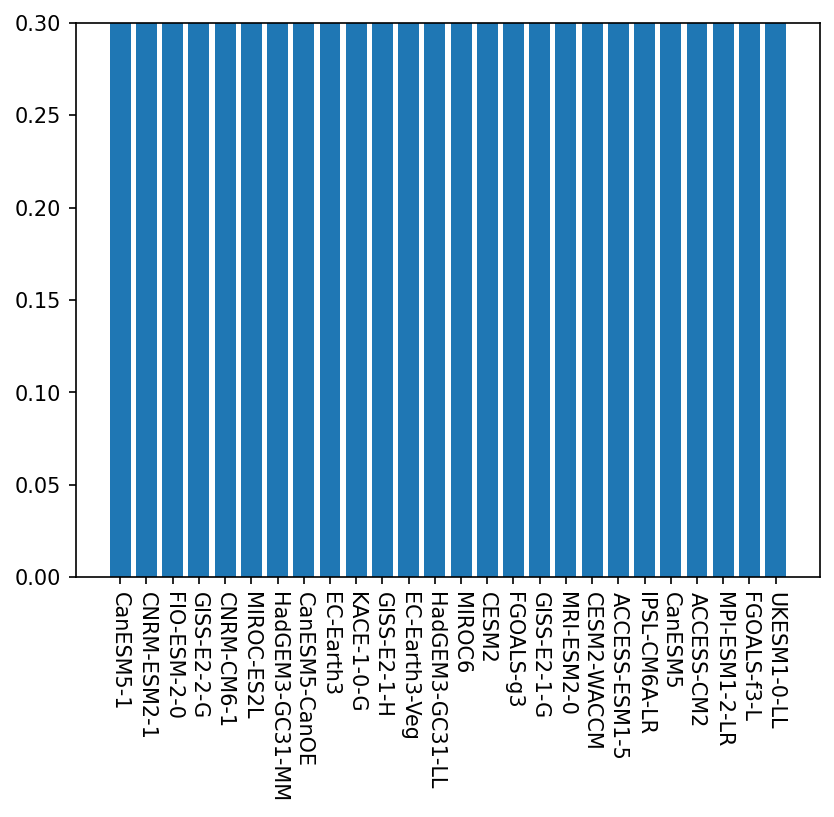

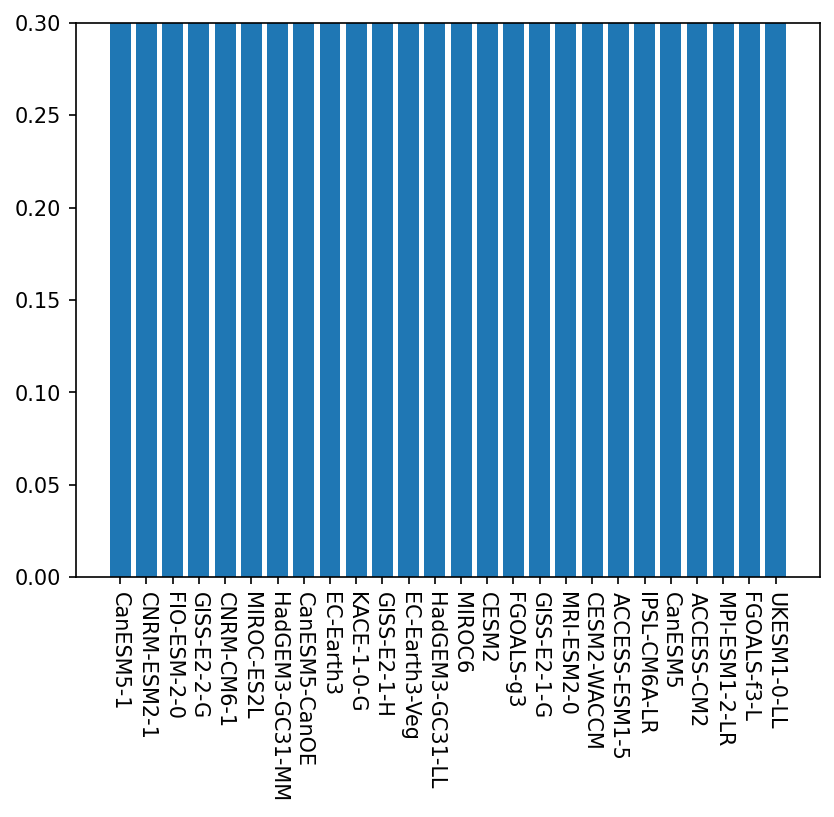

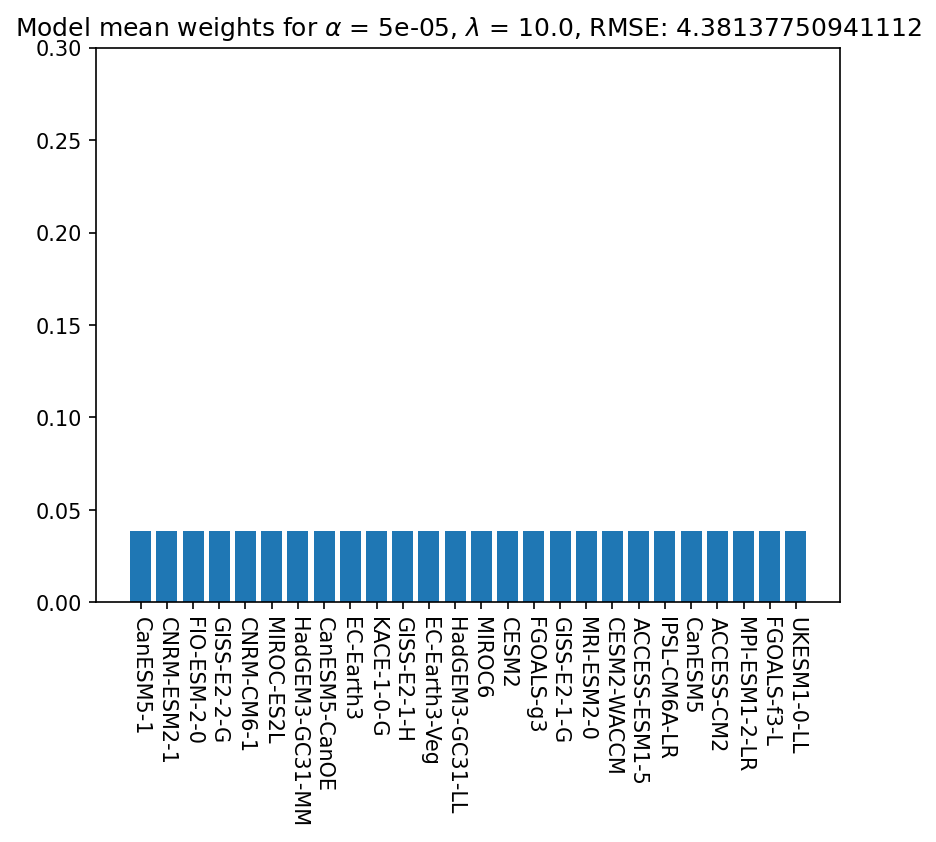

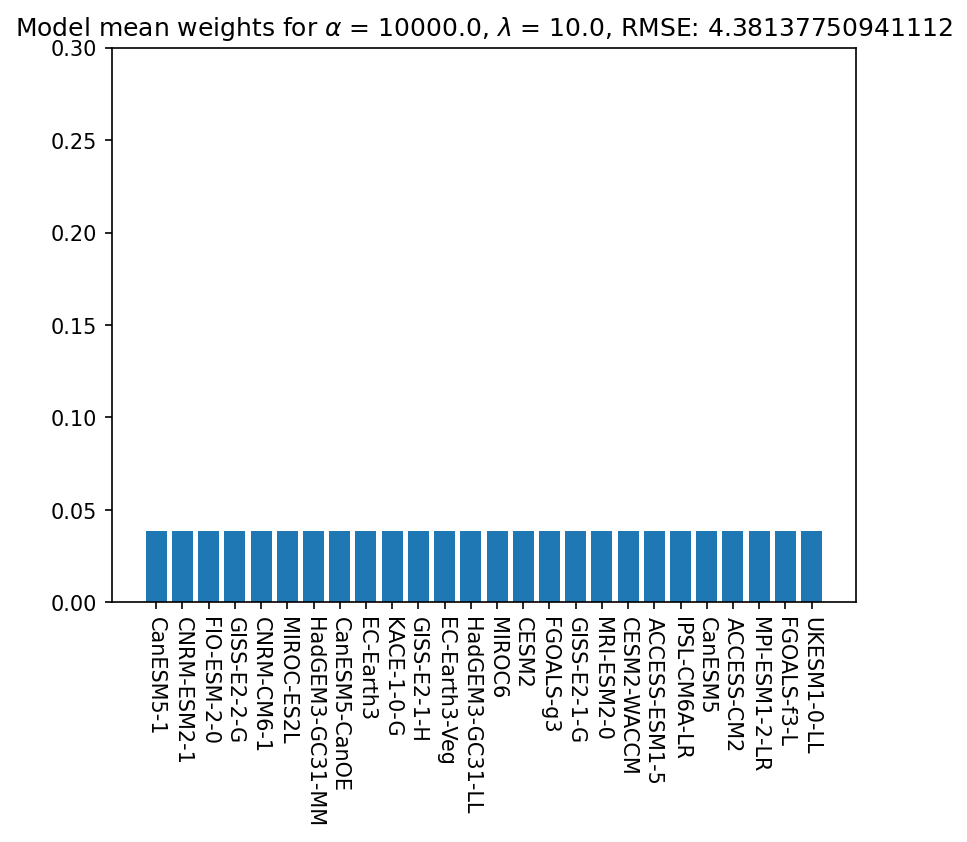

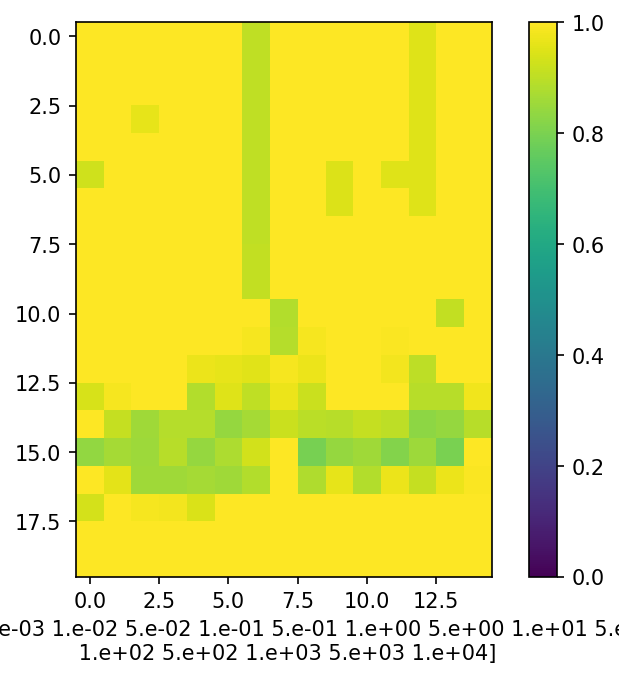

In [40]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(a_map,vmin=0.0, vmax=1.0)
plt.colorbar()
plt.xlabel(lambda_range)
plt.savefig("results/rmse_map_robust.eps", dpi=150)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41520/2200102612.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(alphas, rotation=-90)


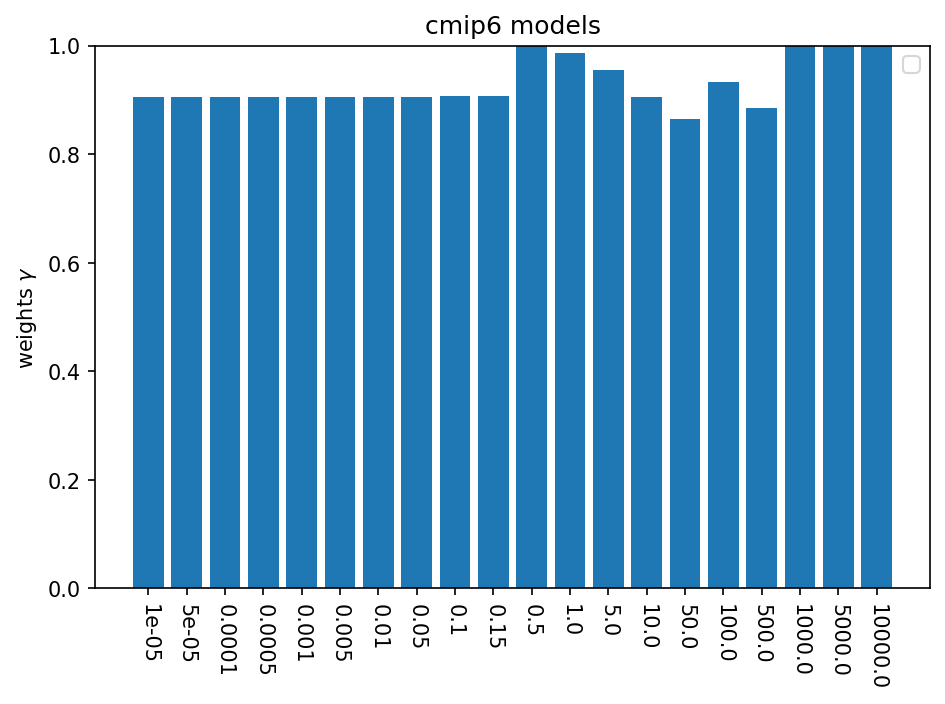

In [41]:
# plot all the bars corresponding to worst case rmse
fig, ax = plt.subplots()
alphas = [str(i) for i in alpha_range]
val_plot = list(a_map[:,6])
ax.set_ylabel(r'weights $\gamma$')
ax.set_ylim(0.0,1.0)
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(alphas, rotation=-90)
ax.bar(alphas, val_plot,label='Model weights')
plt.tight_layout()
# plt.savefig("results/weights_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

# plot the best betas and the best rmse

In [43]:
best_beta = beta_robust[(best_alpha,best_lambda)]
best_weights = weights_robust[(best_alpha,best_lambda)]
best_rmse = rmse_robust[(best_alpha,best_lambda)]

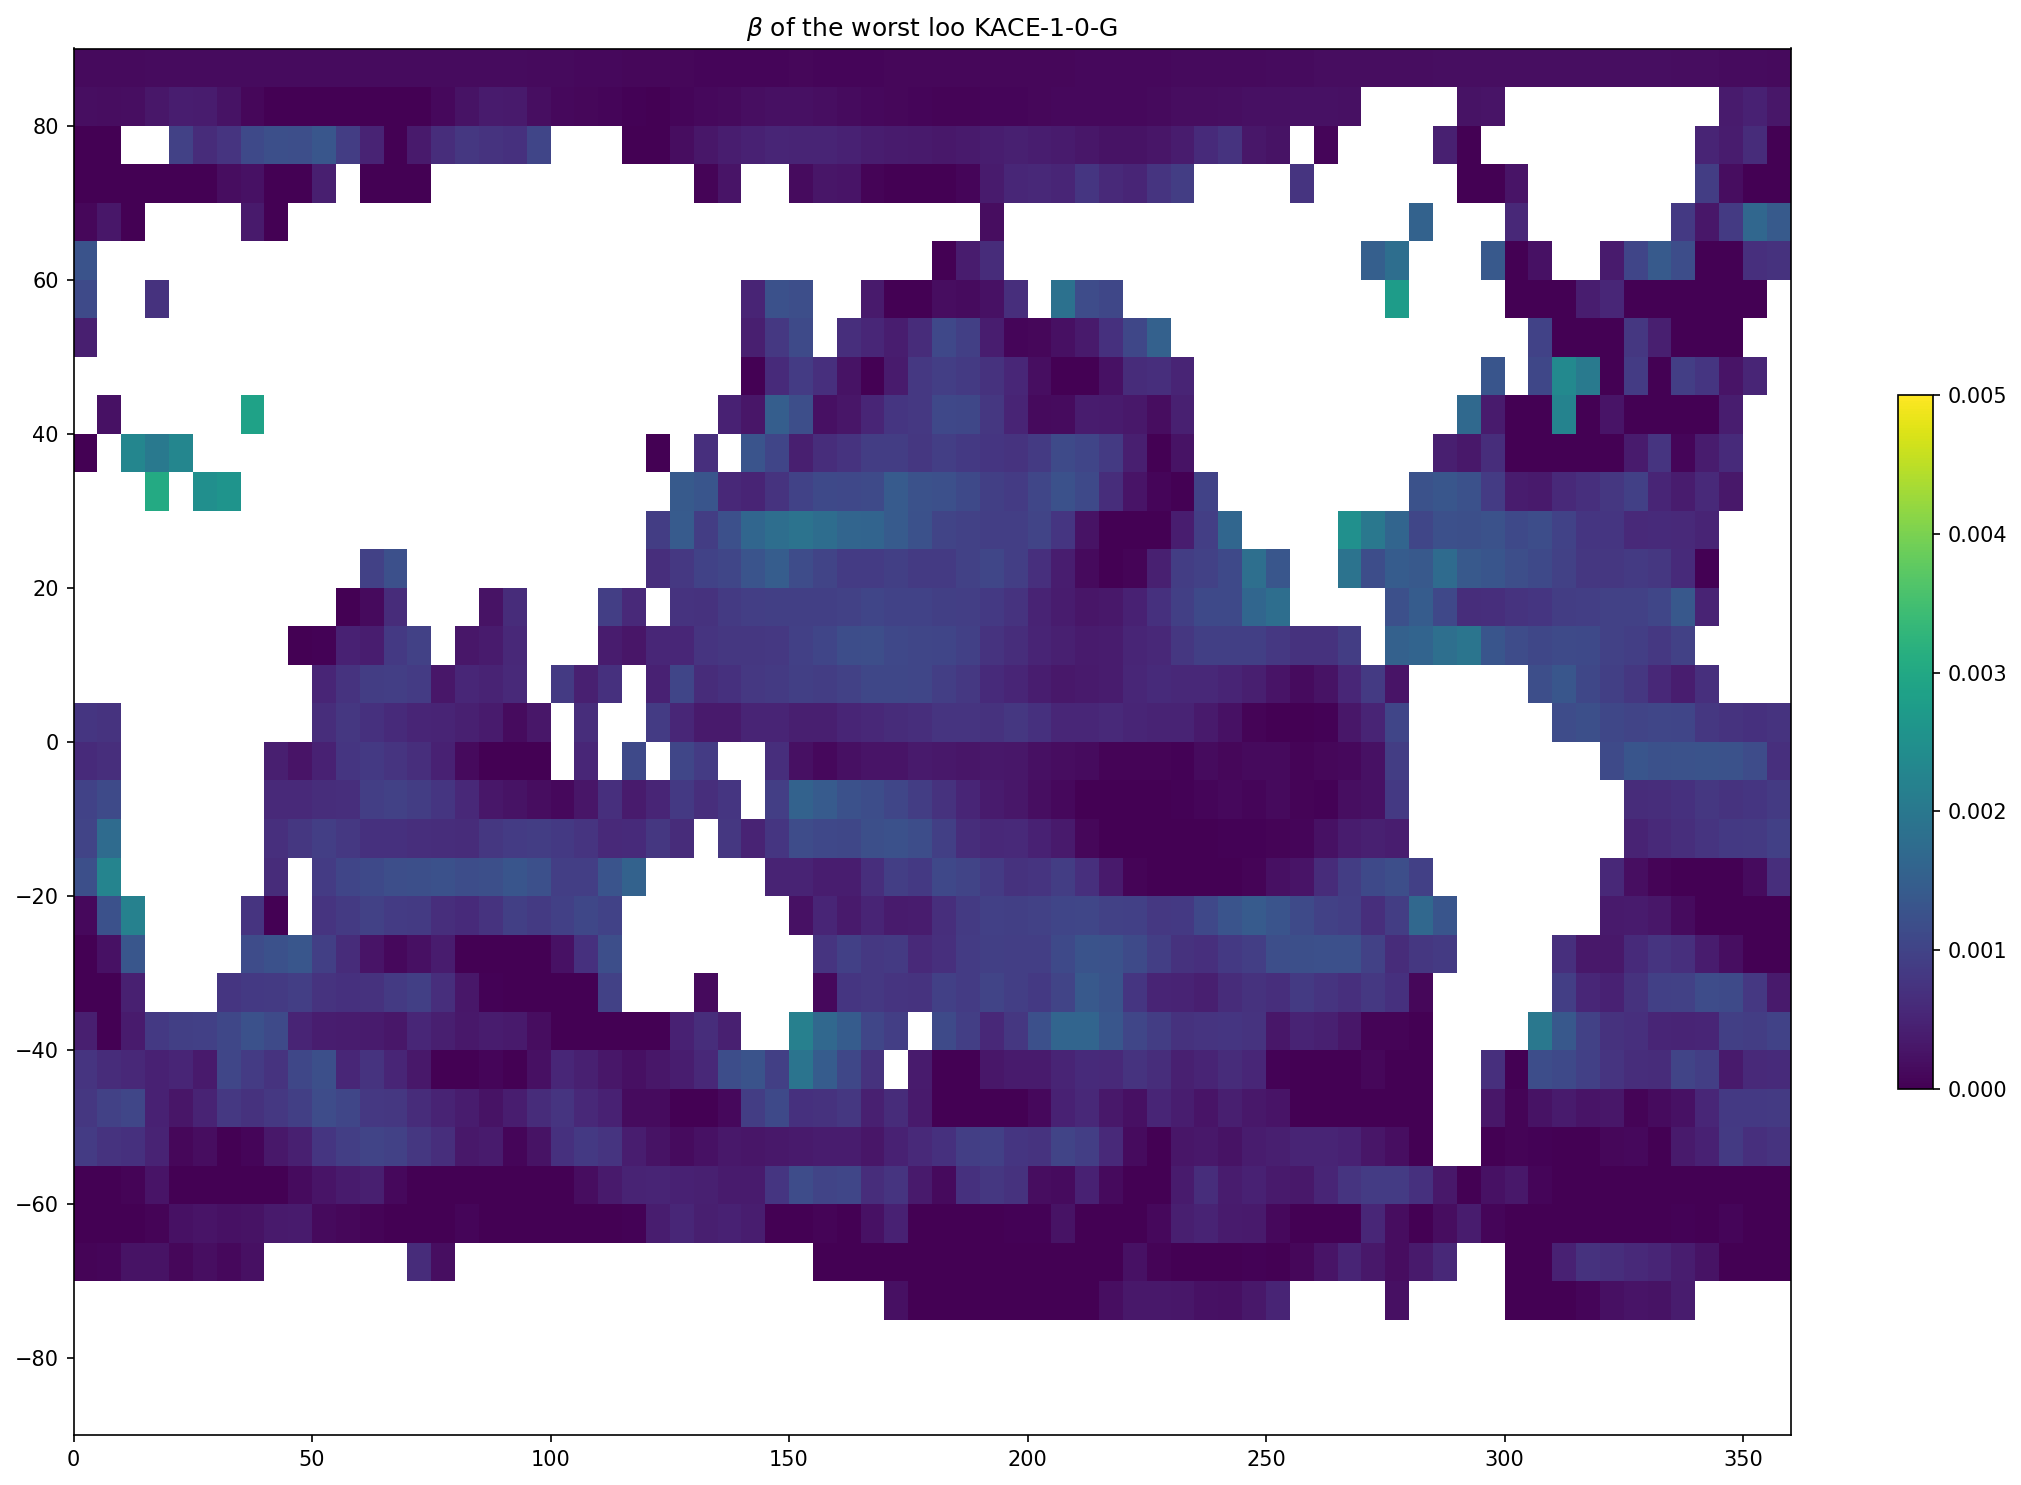

In [44]:
############## plot the beta map for each leave-one-out run #####################################
fig, axs = plt.subplots(1,1, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    
best_beta_tmp = best_beta[worst_loo_idx[(best_alpha,best_lambda)]]
best_beta_tmp = best_beta_tmp.detach().clone()
best_beta_tmp[nans_idx] = float('nan')
beta_tmp = best_beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

axs.set_title(r"$\beta$ of the worst loo " + worst_loo_idx[(best_alpha,best_lambda)])
im0 = axs.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.005)
plt.colorbar(im0, ax=axs, shrink=0.5)

# axs[0].set_title("Weights of the worst loo",worst_loo_idx[(best_alpha,best_lambda)])
# im0 = axs[0].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.005)
# plt.colorbar(im0, ax=axs[0], shrink=0.5)

fig.tight_layout()
# plt.savefig("results/beta_map_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

/tmp/ipykernel_41520/3038416636.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


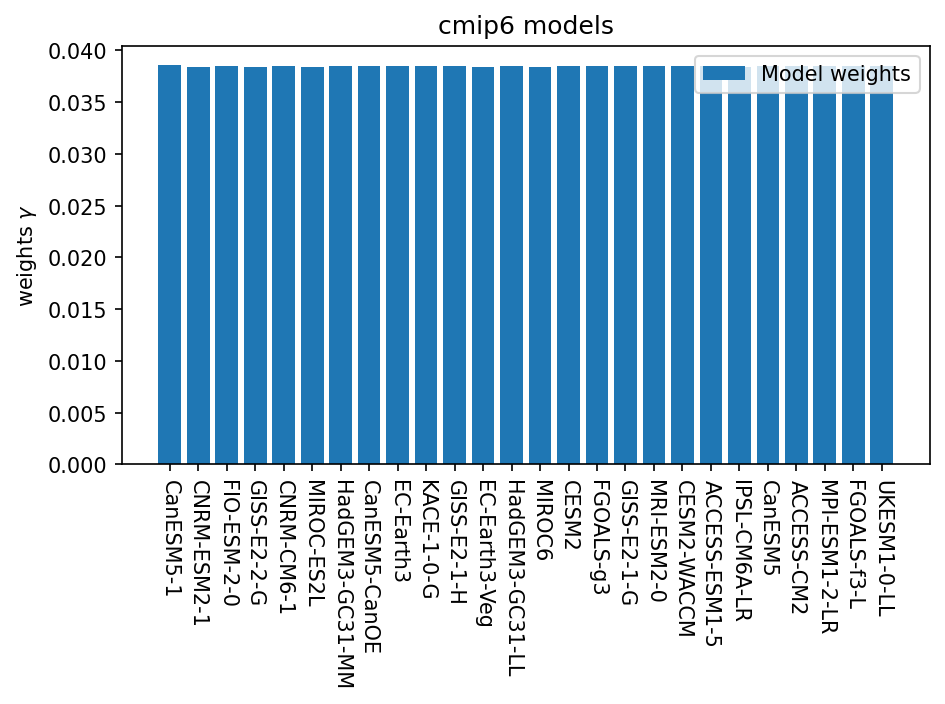

In [45]:
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys()) 
weights_plot = list(weights_robust[(best_alpha,best_lambda)].values()) 
ax.bar(models, weights_plot,label='Model weights')
ax.set_ylabel(r'weights $\gamma$')
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

In [11]:
# fig, ax = plt.subplots()
# models = list(x.keys()) 
# rmse_plot = list(rmse.values()) 
# ax.bar(models, rmse_plot,label='rmse')
# ax.set_ylabel(r'LOO')
# ax.set_title('LOO rmse')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.savefig("results/rmse_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
# plt.show()

In [12]:
######## Plot LOO(m) for different value of alpha. (Make a gif or animation)
# loo_alpha_lambda = np.zeros((alpha_range.shape[0],lambda_range.shape[0]))

# # for each lambda:
# for idx_lambda, lambda_ in enumerate(lambda_range):    

#     # for each pair (alpha, lambda)
#     for idx_alpha, alpha_ in enumerate(alpha_range):
        
#         loo_alpha_lambda = np.array(list(rmse_robust[(alpha_,lambda_)].values()))
        
#         # Bar plot
#         fig, ax = plt.subplots()
#         ax.bar(x = list(rmse_robust[(alpha_,lambda_)].keys()), height = loo_alpha_lambda)
#         ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)
#         plt.show()

# Generate the gif for varying alpha

## generate gif of loo rmse

In [46]:
from matplotlib import animation

# define grid
alpha_grid, lambda_grid = np.meshgrid(alpha_range, lambda_range, indexing='ij')

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

n=100 #Number of frames
x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,2.0)

def animate_rmse(i):
    ax.set_title(r'$\alpha$ = '+ str(alpha_grid.ravel()[i])+ ', $\lambda$ = '+ str(lambda_grid.ravel()[i]))
    for k, b in enumerate(barcollection):
        b.set_height(list(rmse_robust[(alpha_grid.ravel()[i],lambda_grid.ravel()[i])].values())[k])
    

ani = animation.FuncAnimation(fig, animate_rmse, frames=alpha_grid.ravel().shape[0])
ani.save('robust_loo_rmse.mp4',writer=animation.FFMpegWriter(fps=5))

/tmp/ipykernel_41520/2465599957.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '960x720', '-pix_fmt', 'rgba', '-framerate', '5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'robust_loo_rmse.mp4']' returned non-zero exit status 255.

## generate a gif for a single lambda value

In [47]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()


x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,2.0)


def animate_rmse(i):
    ax.set_title(r' $\alpha$ = '+ str(alpha_range[i])+ ', $\lambda$ = '+ str(best_lambda))
    for k, b in enumerate(barcollection):
        b.set_height(list(rmse_robust[(alpha_range[i],lambda_range[8])].values())[k])
    

animation.FuncAnimation(fig, animate_rmse, frames=alpha_range.shape[0])
# ani.save('robust_loo_rmse.mp4',writer=animation.FFMpegWriter(fps=10))

/tmp/ipykernel_41520/2783526551.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)


# Plot the weight as a gif

In [48]:
fig, ax = plt.subplots()

x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,0.3)

def animate_weight(i):
    ax.set_title(r'Model mean weights for $\alpha$ = '+ str(alpha_range[i])+ ', $\lambda$ = '+ str(lambda_grid.ravel()[8]) + ', RMSE: '+ str(a_map[i,8]))
    for k, b in enumerate(barcollection):
        b.set_height(list(weights_robust[(alpha_range[i],lambda_range[8])].values())[k])

animation.FuncAnimation(fig, animate_weight, frames=alpha_range.shape[0])
# ani_weight.save('robust_weights.mp4',writer=animation.FFMpegWriter(fps=10))

/tmp/ipykernel_41520/1442319080.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
